<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Exploratory Data Analysis - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vishrank


### Imports

In [77]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Minimal Data Cleaning

In [78]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,FAILURETYPE,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,Fillage,YesterdaysAverageSPM,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,chemgroup3_all,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,Tubing,0,75,60,144,108,91,6,TAC_ABOVE_NIP,1,1,1,1,0,0,2,1,19,2,Vertical,N,OTHER_ANCHOR,60,74,53,-21,51,59,109,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,900,NaN,NaN,NaN,UNKNOWN,0,0,0,10025,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,Tubing,0,80,62,168,173,2,0,TAC_BELOW_NIP,1,1,0,0,0,0,2,2,17,2,Vertical,N,OTHER_ANCHOR,54,77,88,12,91,17,109,NaN,SINKER_BARS_W_GUIDED_SUBS,False,mesh enterprise portals,SpecialService,882,179,179,179,Miller LLC,0,0,0,10236,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,NaN,NaN,PACKER_DONNAN,0,0,0,0,0,0,5,5,21,2,Vertical,N,arrowset,NaN,74,56,-18,46,10,57,NaN,SLICK_SINKER_BARS,False,mesh enterprise portals,D,880,106,106,106,Miller LLC,0,0,0,10402,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,86,6,TAC_ABOVE_NIP,1,0,1,0,0,0,2,0,17,1,Vertical,Y,OTHER_ANCHOR,NaN,72,102,30,85,28,113,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,875,98,48,98,Miller LLC,0,0,0,9558,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,NaN,0,80,65,168,127,61,4,TAC_BELOW_NIP,1,0,0,0,0,0,2,4,17,4,LowTangent,N,OTHER_ANCHOR,61,76,123,34,77,16,93,1,SUCKER_RODS_W_GUIDES,True,mesh enterprise portals,SpecialService,875,267,267,171,Miller LLC,0,129,0,9682,1.75,NaN


In [79]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].astype(int)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].astype(int)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['FAILSTART'] = rpdf['FAILSTART'].astype(int)

rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

rpdf['lifetime'] = rpdf['lifetime_end'] - rpdf['lifetime_start']

rpdf.drop(['GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO'], axis=1, inplace=True)

In [80]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

rpdf_cleaned['roduid'] = labelencoder.fit_transform(rpdf_cleaned['roduid'])
rpdf_cleaned['IDWELL'] = labelencoder.fit_transform(rpdf_cleaned['IDWELL'])
rpdf_cleaned['tbguid'] = labelencoder.fit_transform(rpdf_cleaned['tbguid'])
rpdf_cleaned['IDRECJOBPULL'] = labelencoder.fit_transform(rpdf_cleaned['IDRECJOBPULL'])
rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])
rpdf_cleaned['NODEID'] = labelencoder.fit_transform(rpdf_cleaned['NODEID'])

rpdf_cleaned.fillna(0, inplace=True)
rpdf_cleaned.replace([np.inf, -np.inf], 0, inplace=True)  

In [81]:

X = rpdf_cleaned.drop(['FAILSTART', 'lifetime_start', 'lifetime_end', 'lifetime'], axis=1)
y = rpdf_cleaned['lifetime']

#split the data again into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

Feature: roduid, Score: 0.02493
Feature: UWI, Score: 0.02141
Feature: NODEID, Score: 0.01543
Feature: IDWELL, Score: 0.02079
Feature: tbguid, Score: 0.01647
Feature: IDRECJOBPULL, Score: 0.01104
Feature: FAILURETYPE, Score: 0.02282
Feature: H2S_CONCENTRATION, Score: 0.00290
Feature: PrimarySetpoint, Score: 0.00367
Feature: SecondarySetpoint, Score: 0.00156
Feature: StrokeLength, Score: 0.00752
Feature: Fillage, Score: 0.03462
Feature: bha_configuration, Score: 0.05964
Feature: chemgroup1_any, Score: 0.02696
Feature: chemgroup1_all, Score: 0.05215
Feature: chemgroup2_any, Score: 0.01256
Feature: chemgroup2_all, Score: 0.16386
Feature: chemgroup3_any, Score: 0.00000
Feature: max_unguided_dls, Score: 0.02647
Feature: dls_high_in_hole, Score: 0.01592
Feature: gas_anchor_length, Score: 0.02786
Feature: MAX_INCLINATION, Score: 0.02169
Feature: wellbore_category, Score: 0.00099
Feature: manual_scale, Score: 0.00263
Feature: packer_vs_tac, Score: 0.00000
Feature: AVG_PRESS_FLOWLINE, Score: 0.0

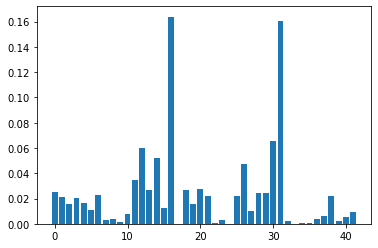

In [82]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
feature_names = list(X_train.columns)

importance = reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [83]:
#score it up
reg.score(X_test, y_test)

-0.09767705721776276

[Text(231.5547564505522, 213.69103448275862, 'X[16] <= 0.5\nmse = 1.2461747170584094e+33\nsamples = 1207\nvalue = 3.9313865919401864e+16'),
 Text(152.21841885290848, 206.19310344827585, 'X[15] <= 0.5\nmse = 6.526743620531957e+32\nsamples = 1092\nvalue = 3.4676563795529284e+16'),
 Text(41.64288938238846, 198.6951724137931, 'X[29] <= 12.373\nmse = 5.586174752355572e+32\nsamples = 861\nvalue = 3.252202697412082e+16'),
 Text(6.451300813812062, 191.19724137931036, 'X[19] <= 0.642\nmse = 3.5663141216175875e+32\nsamples = 61\nvalue = 1.6820297704918032e+16'),
 Text(2.2600520127757617, 183.69931034482758, 'X[0] <= 1118.5\nmse = 6.1284690663555515e+32\nsamples = 9\nvalue = 4.1139833333333336e+16'),
 Text(1.1300260063878809, 176.20137931034483, 'X[29] <= 2.518\nmse = 7.668927775687497e+31\nsamples = 4\nvalue = 1.8322875e+16'),
 Text(0.5650130031939404, 168.70344827586206, 'X[5] <= 1196.0\nmse = 1.1272470502499993e+31\nsamples = 2\nvalue = 1.046655e+16'),
 Text(0.2825065015969702, 161.20551724137

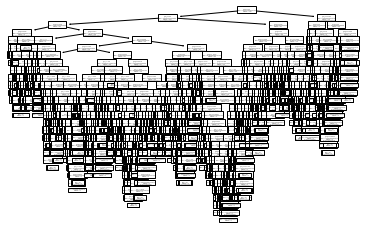

In [85]:
#and export so we can visualize what is going on
dot_data = tree.export_graphviz(reg, out_file='reggraph', feature_names=X.columns, filled=True)
tree.plot_tree(reg)